In [3]:
%matplotlib inline

In [4]:
import os
import numpy as np
import nibabel as nib
import scipy.stats
import matplotlib as mpl
from cmath import rect, phase
import matplotlib.pyplot as plt
import matplotlib.colors as col
from scipy.ndimage.filters import gaussian_filter

In [5]:
def mean_angle(rad):
    return (phase(sum(rect(1, d) for d in rad)/float(len(rad))))

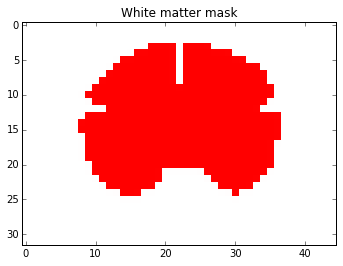

In [7]:
img = nib.load('brain.nii')
data = img.get_data()
slice = data[:,28,:,0]

# XXX DUMMY SLICE

# slice = np.zeros(slice.shape)
# xx, yy = np.mgrid[:slice.shape[0], :slice.shape[1]]
# x0, y0, radius = 15, 15, 10
# circle = (xx - x0)**2 + (yy - y0)**2
# slice = circle <= radius**2
# slice = 255 * slice.astype(np.uint8)

slice_cmap = col.ListedColormap(['white', 'red'])

plt.figure()
plt.imshow(slice.T, interpolation='none', cmap=slice_cmap)
plt.title("White matter mask")

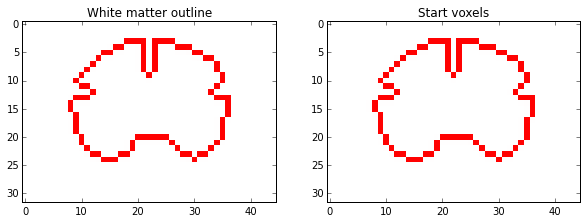

In [8]:
border_voxels = np.zeros_like(slice)
start_voxels = np.zeros_like(slice)
for (i, j), val in np.ndenumerate(slice):
    if i > 0 and i < slice.shape[0] - 1 and j > 0 and j < slice.shape[1] - 1:
        if val > 0:#slice.shape[0]/3:
            if slice[i - 1, j] == 0 \
             or slice[i + 1, j] == 0 \
                or slice[i, j - 1] == 0 \
                or slice[i, j + 1] == 0:
                    border_voxels[i, j] = 1
                    #if i < 9:
                    start_voxels[i, j] = 1

start_voxels_idx = np.where(start_voxels)
n_start_voxels = start_voxels_idx[0].size

border_voxels_idx = np.where(border_voxels)
n_border_voxels = border_voxels_idx[0].size

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(border_voxels.T, interpolation='none', cmap=slice_cmap)
ax1.set_title("White matter outline")
ax2.imshow(start_voxels.T, interpolation='none', cmap=slice_cmap)
ax2.set_title("Start voxels")
                

In [9]:
n_particles = 11000
max_particle_steps = 1000
n_orientation_bins = 16
orientation_bins = np.linspace(0., np.pi, n_orientation_bins)   # left side of each bin
orientation_bins_center = orientation_bins - orientation_bins[0] / 2.

voxel_scale = 1.   # scale factor between "voxel space" and "particle space"
dt = .5  # particle stepsize (in particle space)
m = 10. # particle mass
zeta = 250.  # drift strength - influence of density map gradient (try 50)
noise_ampl = 1.

density_map = np.zeros_like(slice, dtype=np.float)
direction_map = np.zeros((slice.shape[0], slice.shape[1], n_orientation_bins))
grad = [np.zeros_like(density_map), np.zeros_like(density_map)]  # gradient of the density map

start_fibres_perpendicular = True  # set to `True` for starting fibres perpendicular to the surface; `False` to generate a random direction 0..2pi
#start_fibres_perpendicular_range = [-np.pi / 4., np.pi / 4.]   # if ``start_fibres_perpendicular==True``, range of angle offsets from precisely normal to the sujrface

if start_fibres_perpendicular:
    wm_mask_blurred = gaussian_filter(slice, sigma=2)
    wm_gradx, wm_grady = np.gradient(wm_mask_blurred.astype(np.float))

trajectories = []

for particle_idx in range(n_particles):
    if (particle_idx + 1) % 1000 == 0:
        print("Progress: " + str(particle_idx + 1) + " out of " + str(n_particles))
    start_voxel_idx = np.random.randint(n_start_voxels)
    start_voxel = np.array([start_voxels_idx[0][start_voxel_idx], start_voxels_idx[1][start_voxel_idx]], dtype=np.int)
    if start_fibres_perpendicular:
        initial_direction_vector = np.array([wm_gradx[start_voxel[0], start_voxel[1]], wm_grady[start_voxel[0], start_voxel[1]]])
        
        initial_direction_vector += np.array([scipy.stats.uniform(0., np.pi / 8.).rvs(), scipy.stats.uniform(0., np.pi / 8.).rvs()])
        initial_direction_vector /= np.linalg.norm(initial_direction_vector)
    else:
        initial_direction_ang = scipy.stats.uniform(0., 2 * np.pi).rvs()
        initial_direction_vector = np.array([np.cos(initial_direction_ang), np.sin(initial_direction_ang)])

    #
    #   simulate particle trajectory
    #

    #particle_trajectory = []
    #particle_trajectory_voxel = []

    pos = np.array([0., 0.])  # relative position of the particle (i.e. w.r.t. (0, 0))
    vel = np.array([initial_direction_vector[0], initial_direction_vector[1]])  # velocity vector of the particle, always unit length
    for i in range(max_particle_steps):

        voxel_pos = np.round(voxel_scale * pos).astype(np.int) + start_voxel
        
        #
        #  termination condition: particle exited WM mask
        #
        
        if voxel_pos[0] < 0 or voxel_pos[0] >= slice.shape[0] \
         or voxel_pos[1] < 0 or voxel_pos[1] >= slice.shape[1] \
         or slice[tuple(voxel_pos)] == 0:
            break

                                                                                                                                                                                                                                                
        #
        #  logging
        #

        #particle_trajectory.append(np.copy(pos))
        #particle_trajectory_voxel.append(np.copy(voxel_pos))

        if i > 1:
            density_map[tuple(voxel_pos)] += 1
            direction_ang = np.arctan2(vel[1], vel[0])
            if direction_ang < 0.:
                direction_ang += np.pi   # put result in range [0..pi]
            direction_ang_bin = np.digitize([direction_ang], orientation_bins, right=True)
            direction_map[voxel_pos[0], voxel_pos[1], direction_ang_bin] += 1


        #
        #  update state
        #

        if particle_idx > 1 and (particle_idx + 1) % 100 == 0:
            
            #
            # recompute gradient of the density map
            #
            _density_map = density_map / np.amax(density_map)
            grad = np.gradient(gaussian_filter(_density_map, sigma=2))
            
        gradient_vec = np.array([grad[0][tuple(voxel_pos)], grad[1][tuple(voxel_pos)]])                

        noise = noise_ampl * np.random.randn(2)#noise = noise_ampl * scipy.stats.norm(0., 1.).rvs(2) # N.B. rvs() is slow
        dpos = vel
        dvel = (-zeta * gradient_vec + noise) / m

        pos += dt * dpos
        vel += dt * dvel
        vel /= (vel[0]**2 + vel[1]**2)**.5    # velocity stays constant (= 1); fixed stepsize!
        

Progress: 1000 out of 11000
Progress: 2000 out of 11000
Progress: 3000 out of 11000
Progress: 4000 out of 11000
Progress: 5000 out of 11000
Progress: 6000 out of 11000
Progress: 7000 out of 11000
Progress: 8000 out of 11000
Progress: 9000 out of 11000
Progress: 10000 out of 11000
Progress: 11000 out of 11000


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in log


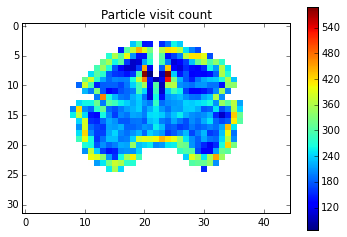

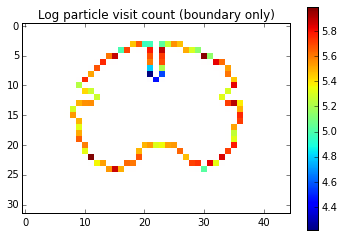

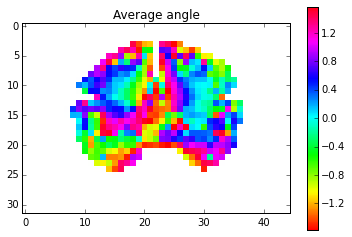

In [10]:
cmap = plt.cm.jet
cmap.set_bad('w', 1.)

def mkcmap():
    white = '#ffffff'
    black = '#000000'
    red = '#ff0000'
    blue = '#0000ff'
    anglemap = col.LinearSegmentedColormap.from_list(
        'anglemap', [black, red, white, blue, black], N=256, gamma=1)
    return anglemap

#cmap_angle = mkcmap()
cmap_angle = plt.cm.hsv
cmap_angle.set_bad('w', 1.)

"""if n_particles <= 100:
    plt.figure()
    masked_array = np.ma.array(density_map, mask=255 - slice)
    plt.imshow(masked_array.T, interpolation="none")
    plt.title("Particle visit count + trajectories")
    for particle_idx in range(n_particles):
        _traj = np.array(trajectories[particle_idx])
        plt.plot(_traj[:, 0], _traj[:, 1], "o-")
    plt.colorbar()"""

plt.figure()
masked_array = np.ma.array(density_map, mask=255 - slice)
plt.imshow(masked_array.T, interpolation="none")
plt.title("Particle visit count")
plt.colorbar()

plt.figure()
masked_array = np.ma.array(np.log(density_map), mask=1 - border_voxels)
plt.imshow(masked_array.T, interpolation="none")
plt.title("Log particle visit count (boundary only)")
plt.colorbar()


#cmap = plt.cm.hsv
#cmap.set_bad('w', 1.)
norm = mpl.colors.Normalize(vmin=-np.pi/2., vmax=np.pi/2.)
#norm = None


dominant_direction_map = np.empty_like(density_map)
for i in range(density_map.shape[0]):
    for j in range(density_map.shape[1]):
        idx = np.where(direction_map[i, j, :] > 0)[0]
        _list = []
        for k in idx:
            _list.extend(int(direction_map[i, j, k]) * [orientation_bins_center[k]])
        _list = np.array(_list)
        if len(_list) > 0:
#             dominant_direction_map[i, j] = mean_angle(np.array(_list))
            dominant_direction_map[i, j] = mean_angle(2 * np.array(_list)) / 2.
#             print("min="+str(np.amin(_list))+", max="+str(np.amax(_list)))
        else:
            dominant_direction_map[i, j] = np.nan
                
#         if len(idx) == 0:
#             dominant_direction_map[i, j] = np.nan
#         else:
#             dominant_direction_map[i, j] = mean_angle(direction_map[i, j, idx] * [orientation_bins[idx]])
#             print("idx = " + str(idx) + ", val = " + str(direction_map[i, j, idx]) + ", val2 = " + str(orientation_bins[idx]) + ", ang = " + str(dominant_direction_map[i, j]))

plt.figure()
masked_array = np.ma.array(dominant_direction_map, mask=255 - slice)
plt.imshow(masked_array.T, interpolation='none', cmap=cmap_angle, norm=norm)
plt.title("Average angle")
plt.colorbar()


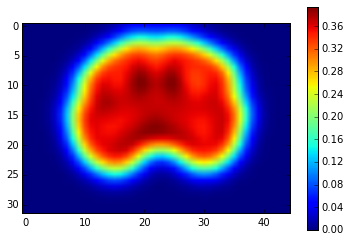

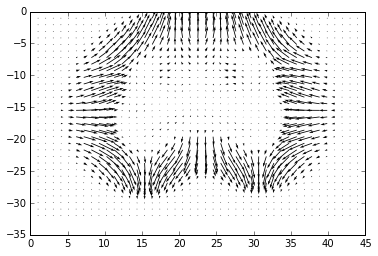

In [11]:
_density_map = density_map / np.amax(density_map)
grad = np.gradient(gaussian_filter(_density_map, sigma=2))

plt.figure()
plt.imshow(gaussian_filter(_density_map, sigma=2).T)
plt.colorbar()

plt.figure()
X, Y = np.meshgrid(np.linspace(0, _density_map.shape[0], _density_map.shape[0]), np.linspace(0, _density_map.shape[1], _density_map.shape[1]))
plt.quiver(X.T, -Y.T, grad[0], grad[1])

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.4/dist-packages/matplotlib/quiver.py:677: RuntimeWarning: divide by zero encountered in true_divide
  shrink = length / minsh
/usr/local/lib/python3.4/dist-packages/matplotlib/quiver.py:678: RuntimeWarning: invalid value encountered in multiply
  X0 = shrink * X0[np.newaxis, :]
/usr/local/lib/python3.4/dist-packages/matplotlib/quiver.py:679: RuntimeWarning: invalid value encountered in multiply
  Y0 = shrink * Y0[np.newaxis, :]


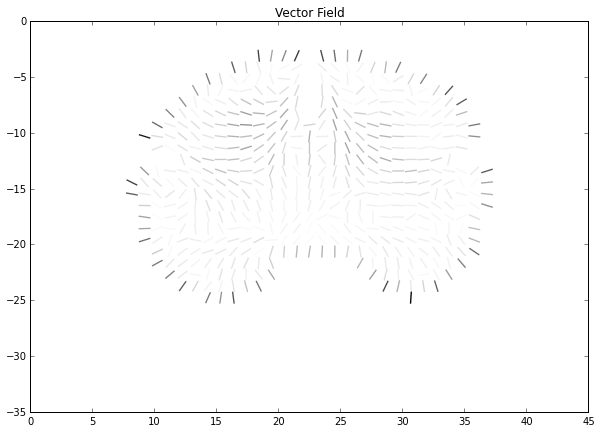

In [12]:
# transform angles into vectors

#X, Y = np.meshgrid(np.arange(0, slice.shape[0]), -np.arange(0, slice.shape[1]))
X, Y = np.meshgrid(np.linspace(0, _density_map.shape[0], _density_map.shape[0]), np.linspace(0, _density_map.shape[1], _density_map.shape[1]))

VX = np.cos(dominant_direction_map)
VY = -np.sin(dominant_direction_map)

# Pearson's chi-squared test to quantify deviation from uniform distribution
E = 1 / float(n_orientation_bins)
chi_sq = np.zeros_like(dominant_direction_map)
for (i, j), val in np.ndenumerate(dominant_direction_map):
    for k in range(n_orientation_bins):
        chi_sq[i, j] += (direction_map[i, j, k] / np.sum(direction_map[i, j, :]) - E)**2 / E

chi_sq[np.isnan(chi_sq)] = 0.

plt.figure(figsize=(10, 7))
plt.quiver(X.T, -Y.T, VX, VY, chi_sq,
           pivot="mid",
           scale=6,
           scale_units='inches',
           cmap=plt.cm.gray_r,
           norm=mpl.colors.Normalize(vmin=0, vmax=np.amax(chi_sq)),
           headaxislength=0,
           headlength=0)

plt.title('Vector Field')
plt.show()